# Classification Analysis

Lastly, we will analyze which images our model classified correctly and incorrectly to see if we can gain any insight into how to improve it.

## Table of Contents
1. [Build Model](#model) <br>
2. [Get Indices of Images and Their Classifications](#index) <br>
3. [Viewing Images From Each Class](#view) <br>
    1. [True Positives](#tp) <br>
    2. [True Negatives](#tn) <br>
    3. [False Positives](#fp) <br>
    4. [False Negatives](#fn) <br>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras import models, layers
import metric_functions as mf
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Build Model <a id='model'></a>

Below we collect our data and build our best model once more.

In [4]:
train_folder = os.path.join('train')
train_pneum = os.path.join(train_folder, 'PNEUMONIA')
train_norm = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join('test')
test_pneum = os.path.join(test_folder, 'PNEUMONIA')
test_norm = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join('val')
val_pneum = os.path.join(val_folder, 'PNEUMONIA')
val_norm = os.path.join(val_folder, 'NORMAL')

In [5]:
print('There are', len(os.listdir(train_pneum)), 'pneumonia images in the train set')
print('There are', len(os.listdir(train_norm)), 'normal images in the train set')
print('There are', len(os.listdir(test_pneum)), 'pneumonia images in the test set')
print('There are', len(os.listdir(test_norm)), 'normal images in the test set')
print('There are', len(os.listdir(val_pneum)), 'pneumonia images in the val set')
print('There are', len(os.listdir(val_norm)), 'normal images in the val set')

There are 3108 pneumonia images in the train set
There are 1080 normal images in the train set
There are 390 pneumonia images in the test set
There are 234 normal images in the test set
There are 777 pneumonia images in the val set
There are 271 normal images in the val set


In [6]:
train_generator_128 = ImageDataGenerator(rescale=1./255,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1,
                                          shear_range=15,
                                          zoom_range=[.9, .9]).flow_from_directory(train_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 4188)
test_generator_128 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 624)
val_generator_128 = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 1048)

Found 4186 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [7]:
train_images_128, train_labels_128 = next(train_generator_128)
test_images_128, test_labels_128 = next(test_generator_128)
val_images_128, val_labels_128 = next(val_generator_128)
train_y_128 = np.reshape(train_labels_128[:,1], (4186,1))
test_y_128 = np.reshape(test_labels_128[:,1], (624,1))
val_y_128 = np.reshape(val_labels_128[:,1], (1046,1))
print ("train_images shape: " + str(train_images_128.shape))
print ("train_labels shape: " + str(train_labels_128.shape))
print ("test_images shape: " + str(test_images_128.shape))
print ("test_labels shape: " + str(test_labels_128.shape))
print ("val_images shape: " + str(val_images_128.shape))
print ("val_labels shape: " + str(val_labels_128.shape))

train_images shape: (4186, 128, 128, 1)
train_labels shape: (4186, 2)
test_images shape: (624, 128, 128, 1)
test_labels shape: (624, 2)
val_images shape: (1046, 128, 128, 1)
val_labels shape: (1046, 2)


In [8]:
class_labels = list(train_generator_128.class_indices.keys())

In [12]:
model_12_128_6_quad_rmsprop = models.load_model('model_12_128_6_quad_rmsprop.hdf5')

# Get Indices of Images and Their Classifications <a id='index'></a>

First, we will create a function which will iterate through our model's prections for the test set and their ground truth values. It will then collect the index of all images according to how they were classified.

In [18]:
def generate_confusion_indices(test_y_true, test_y_pred):
    """Returns lists of index of images classified as TP, TN, FP, or FN."""
    a = test_y_true.astype(int).reshape(len(test_y_true),)
    b = test_y_pred.astype(int).reshape(len(test_y_pred),)
    true_vs_pred = list(zip(a, b))
    
    x = 0                # (truth, pred)
    true_positives = []  # (1, 1)
    true_negatives = []  # (0 ,0)
    false_positives = [] # (1, 0)
    false_negatives = [] # (0, 1) TIM FIX THIS PLS
    
    for pair in true_vs_pred:
        if pair[0] == 1 and pair[1] == 1:
            true_positives.append(x)
        if pair[0] == 0 and pair[1] == 0:
            true_negatives.append(x)
        if pair[0] == 1 and pair[1] == 0:
            false_positives.append(x)
        if pair[0] == 0 and pair[1] == 1:
            false_negatives.append(x)
        x += 1
    
    print('True positives:', len(true_positives))
    print('True negatives:', len(true_negatives))
    print('False positives:', len(false_positives))
    print('False negatives:', len(false_negatives))
    
    return true_positives, true_negatives, false_positives, false_negatives

In [19]:
y_pred = model_12_128_6_quad_rmsprop.predict_classes(test_images_128)

In [20]:
true_positives, true_negatives, false_positives, false_negatives = generate_confusion_indices(test_y_128, y_pred)

True positives: 376
True negatives: 187
False positives: 14
False negatives: 47


# Viewing Images From Each Class <a id='view'></a>

## True Positives <a id='tp'></a>

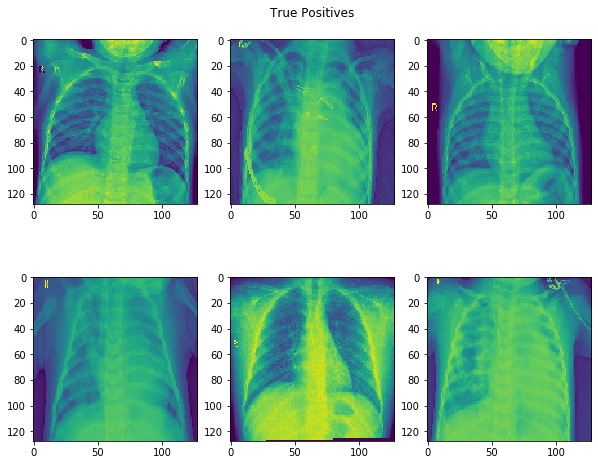

In [53]:
f = plt.figure(figsize=(10,8))
plt.title('True Positives')
plt.axis('off')
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)
ax1.imshow(array_to_img(test_images_128[true_positives[0]]))
ax2.imshow(array_to_img(test_images_128[true_positives[1]]))
ax3.imshow(array_to_img(test_images_128[true_positives[2]]))
ax4.imshow(array_to_img(test_images_128[true_positives[3]]))
ax5.imshow(array_to_img(test_images_128[true_positives[4]]))
ax6.imshow(array_to_img(test_images_128[true_positives[5]]))
plt.show()

## True Negatives <a id='tn'></a>

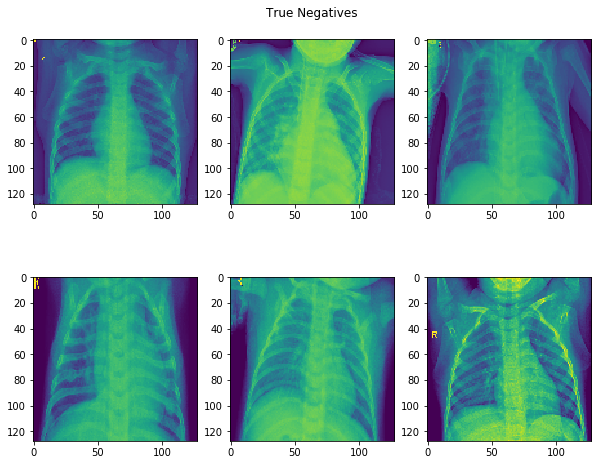

In [54]:
f = plt.figure(figsize=(10,8))
plt.title('True Negatives')
plt.axis('off')
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)
ax1.imshow(array_to_img(test_images_128[true_negatives[0]]))
ax2.imshow(array_to_img(test_images_128[true_negatives[1]]))
ax3.imshow(array_to_img(test_images_128[true_negatives[2]]))
ax4.imshow(array_to_img(test_images_128[true_negatives[3]]))
ax5.imshow(array_to_img(test_images_128[true_negatives[4]]))
ax6.imshow(array_to_img(test_images_128[true_negatives[5]]))
plt.show()

## False Positives <a id='fp'></a>

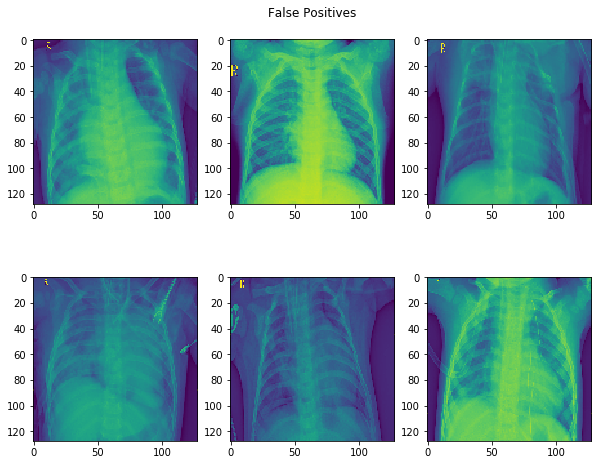

In [55]:
f = plt.figure(figsize=(10,8))
plt.title('False Positives')
plt.axis('off')
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)
ax1.imshow(array_to_img(test_images_128[false_positives[0]]))
ax2.imshow(array_to_img(test_images_128[false_positives[1]]))
ax3.imshow(array_to_img(test_images_128[false_positives[2]]))
ax4.imshow(array_to_img(test_images_128[false_positives[3]]))
ax5.imshow(array_to_img(test_images_128[false_positives[4]]))
ax6.imshow(array_to_img(test_images_128[false_positives[5]]))
plt.show()

## False Negatives <a id='fn'></a>

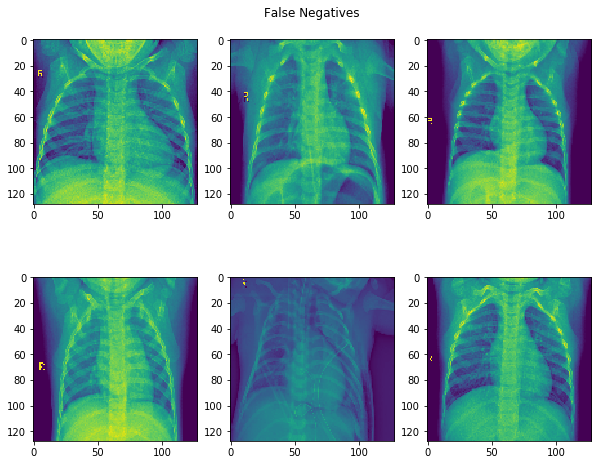

In [56]:
f = plt.figure(figsize=(10,8))
plt.title('False Negatives')
plt.axis('off')
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)
ax1.imshow(array_to_img(test_images_128[false_negatives[0]]))
ax2.imshow(array_to_img(test_images_128[false_negatives[1]]))
ax3.imshow(array_to_img(test_images_128[false_negatives[2]]))
ax4.imshow(array_to_img(test_images_128[false_negatives[3]]))
ax5.imshow(array_to_img(test_images_128[false_negatives[4]]))
ax6.imshow(array_to_img(test_images_128[false_negatives[5]]))
plt.show()

We don't see any significant difference between the images which could help us to better our parameters for our models.